In [1]:
from symbolfit.symbolfit import *

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


# Dataset

Five inputs are needed, which can be python lists or numpy arrays (more options will be added in future!):
1. ``x``: independent variable (bin center location).
2. ``y``: dependent variable.
3. ``y_up``: upward uncertainty in y per bin.
4. ``y_down``: downward uncertainty in y per bin.
5. ``bin_widths_1d`` bin widths in x.
- Elements in both y_up and y_down should be non-negative values.
- These values are the "delta" in y,
  - y + y_up = y shifted up by one standard deviation.
  - y - y_down = y shifted down by one standard deviation.
- If no uncertainty in the dataset, one can set both y_up and y_down to ones with the same shape as x.

In [2]:
x = [12.5, 37.5, 62.5, 87.5, 112.5, 137.5, 162.5, 187.5, 212.5, 237.5, 262.5, 287.5, 312.5, 337.5, 362.5, 387.5, 412.5, 437.5, 462.5, 487.5]
y = [10.234884262084961, 122.1119384765625, 338.9125061035156, 810.2549438476562, 649.0571899414062, 351.8170166015625, 248.619873046875, 186.88763427734375, 141.754150390625, 103.42931365966797, 78.36450958251953, 60.3994255065918, 49.005863189697266, 33.54744338989258, 27.76025390625, 25.299283981323242, 19.729631423950195, 14.033162117004395, 15.06820011138916, 9.641764640808105]
y_up = [3.199200566092248, 11.050427072134475, 18.409576478113657, 28.464977495997715, 25.476600831771226, 18.756785881423355, 15.767684454189048, 13.670685216087149, 11.906055198537633, 10.170020337229811, 8.852373104570296, 7.771706730608908, 7.000418786736781, 5.7920154859852175, 5.268800044246317, 5.029839359395411, 4.441804973650936, 3.746086239931536, 3.8817779575072504, 3.105119102515732]
y_down = [3.199200566092248, 11.050427072134475, 18.409576478113657, 28.464977495997715, 25.476600831771226, 18.756785881423355, 15.767684454189048, 13.670685216087149, 11.906055198537633, 10.170020337229811, 8.852373104570296, 7.771706730608908, 7.000418786736781, 5.7920154859852175, 5.268800044246317, 5.029839359395411, 4.441804973650936, 3.746086239931536, 3.8817779575072504, 3.105119102515732]
bin_widths_1d = [25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25]

Plot the dataset to see what we will be fitting to:

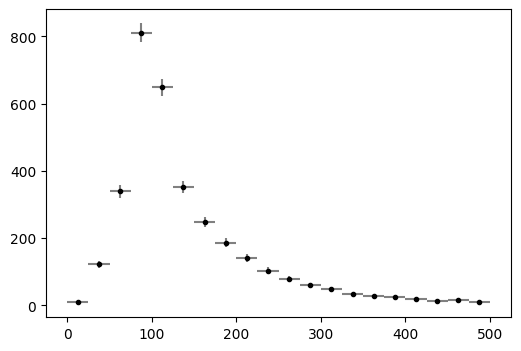

In [3]:
fig, axes = plt.subplots(figsize = (6, 4))
plt.errorbar(np.array(x).flatten(),
             np.array(y).flatten(),
             yerr = [np.array(y_down).flatten(), np.array(y_up).flatten()],
             xerr = np.array(bin_widths_1d)/2,
             fmt = '.', c = 'black', ecolor = 'grey', capsize = 0,
            )
plt.savefig('img/toy1/dataset.png')

# Configure the fit

Configure PySR to define the function space being searched for with symbolic regression:

In [4]:
from pysr import PySRRegressor
import sympy

pysr_config = PySRRegressor(
    model_selection = 'accuracy',
    niterations = 200,
    maxsize = 60,
    binary_operators = [
        '+', '*'
                     ],
    unary_operators = [
        'exp',
        'gauss(x) = exp(-x*x)',
        'tanh',
    ],
    nested_constraints = {
        'tanh':   {'tanh': 0, 'exp': 0, 'gauss': 0, '*': 2},
        'exp':    {'tanh': 0, 'exp': 0, 'gauss': 0, '*': 2},
        'gauss':  {'tanh': 0, 'exp': 0, 'gauss': 0, '*': 2},
        '*':      {'tanh': 1, 'exp': 1, 'gauss': 1, '*': 2},
    },
    extra_sympy_mappings={
        'gauss': lambda x: sympy.exp(-x*x),
                         },
    loss='loss(y, y_pred, weights) = (y - y_pred)^2 * weights',
)

Here, we allow two binary operators (+, *) and three unary operators (exp, gauss, tanh) when searching for functional forms.
The custom-defined gauss is there because this dataset has a peak. One can define any other function they want for their shapes.

Nested constraints are imposed to prohibit, e.g., exp(exp(x))...

Loss function is a weighted MSE, where the weight is the sqaured uncertainty by default in SymbolFit.

For PySR options, please see:
- https://github.com/MilesCranmer/PySR
- https://astroautomata.com/PySR/

Configure SymbolFit with the PySR config and for the re-optimization process:

In [5]:
model = SymbolFit(
        # Dataset: x, y, y_up, y_down.
    	x = x,
    	y = y,
    	y_up = y_up,
    	y_down = y_down,
    
        # PySR configuration of the function space.
    	pysr_config = pysr_config,
    
        # Constrain the maximum function size and over-write maxsize in pysr_config.
        # Set a higher value for more complex shape, or when the lower one does not fit well.
    	max_complexity = 60,
    
        # Whether to scale input x to be within 0 and 1 for the fits for numerical stability,
        # as large x could lead to overflow when there is e.g. exp(x) -> exp(10000).
        # So set this to False when your x's are or close to O(1), otherwise recommended to set True.
        # After the fits, the functions will be unscaled to relect the original dataset.
    	input_rescale = True,
    
        # Whether to scale y for the fits for numerical stability,
        # options are (when input_rescale is True): None / 'mean' / 'max' / 'l2'.
        # This is useful to stabilize fits when your y's are very large or very small.
        # After the fits, the functions will be unscaled to relect the original dataset.
    	scale_y_by = 'mean',
    
        # Set a maximum standard error (%) for all parameters to avoid bad fits during re-optimization.
        # In the refit loop, when any of the parameters returns a standard error larger than max_stderr,
        # the fit is considered failed, and the fit will retry itself for fewer or other combination of varying parameters,
        # by freezing some of the parameters to their initial values and kept fixed during re-optimization.
        # This is to avoid bad fits when the objective is too complex to minimize, which could cause some parameters
        # to have unrealistically large standard errors.
        # In most cases 10 < max_stderr < 100 suffices.
    	max_stderr = 20,
    
        # Consider y_up and y_down to weight the MSE loss during SR search and re-optimization.
    	fit_y_unc = True,
    
        # Set a random seed for returning the same batch of functional forms every time (single-threaded),
        # otherwise set None to explore more functions every time (multi-threaded and faster).
        # In most cases the function space is huge, one can retry the fits with the exact same fit configuration
        # and get completely different sets of candidate functions, merely by using different random seeds.
        # So if the candidate functions are not satisfactory this time, rerun it few times more with
        # random_seed = None or a different seed each time.
    	random_seed = None,
    
        # Custome loss weight to set "(y - y_pred)^2 * loss_weights", overwriting that with y_up and y_down.
    	loss_weights = None
)

# Symbol Fit it!

Run the fits: SR fit for functional form searching -> parameterization -> re-optimization fit for improved best-fits and uncertainty estimation -> evaluation.

In [6]:
model.fit()

Compiling Julia backend...


[ Info: Started!



Expressions evaluated per second: 4.880e+05
Head worker occupation: 16.8%
Progress: 1073 / 3000 total iterations (35.767%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
1           1.640e-01  1.594e+01  y = 0.217
2           1.639e-01  3.594e-04  y = tanh(0.217)
3           1.639e-01  3.114e-04  y = 0.06188 + 0.14463
4           1.530e-01  6.836e-02  y = gauss(x₀) * 0.28092
5           1.498e-01  2.151e-02  y = gauss(x₀) * exp(-1.0052)
7           1.482e-01  5.400e-03  y = (gauss(x₀) + -0.26503) * gauss(-0.6659)
8           1.253e-01  1.673e-01  y = gauss(0.65944 + (-2.1137 * x₀)) * 0.65944
9           9.068e-02  3.237e-01  y = gauss(x₀ + x₀) * tanh(12.389 * x₀)
10          3.253e-02  1.025e+00  y = 0.10657 + (gauss(x₀ * -4.135) * (32.753 * x₀))
12          2.345e-02  1.636e-01  y = 0.10123 + ((2.9992 * x₀) * (gauss(x₀ * 3.7439) * 7.7795))
13          2.314e-02  1.327e-02  y =

## Save results to output files

Save results to csv tables:
- ``candidates.csv``: saves all candidate functions and evaluations in a csv table.
- ``candidates_reduced.csv``: saves a reduced version for essential information without intermediate results.

In [7]:
model.save_to_csv(output_dir = 'output_Toy_dataset_1/')

Saving full results >>> output_Toy_dataset_1/candidates.csv
Saving reduced results >>> output_Toy_dataset_1/candidates_reduced.csv


Plot results to pdf files:
- ``candidates.pdf``: plots all candidate functions with associated uncertainties one by one for fit quality evaluation.
- ``candidates_sampling.pdf``: plots all candidate functions with total uncertainty coverage generated by sampling parameters.
- ``candidates_gof.pdf``: plots the goodness-of-fit scores.
- ``candidates_correlation.pdf``: plots the correlation matrices for the parameters of the candidate functions.

In [8]:
model.plot_to_pdf(
    	output_dir = 'output_Toy_dataset_1/',
    	bin_widths_1d = bin_widths_1d,
    	#bin_edges_2d = bin_edges_2d,
    	plot_logy = False,
    	plot_logx = False,
        sampling_95quantile = False
)

Plotting candidate functions 44/44 >>> output_Toy_dataset_1/candidates.pdf
Plotting candidate functions (sampling parameters) 44/44 >>> output_Toy_dataset_1/candidates_sampling.pdf
Plotting correlation matrices 44/44 >>> output_Toy_dataset_1/candidates_correlation.pdf
Plotting goodness-of-fit scores >>> output_Toy_dataset_1/candidates_gof.pdf
